# COMP S493F Lab 11

In [2]:
%env TF_CPP_MIN_LOG_LEVEL=2
import tensorflow as tf
tf.config.experimental.enable_op_determinism()

env: TF_CPP_MIN_LOG_LEVEL=2


In this lesson, you'll work on:

- text classification and text generation, and
- using LSTM, GRU, stacked RNN, and bidirectional RNN.

### Student name: *Lo Tsz Kin*

# The 20 newsgroups text dataset

The scikit-learn library provides the 20 newsgroups text dataset, which contains about 18,000 messages in 20 newsgroups. To load the dataset, invoke the `fetch_20newsgroups()` function, as shown in the following code. This function returns a bunch object with these attributes (among others): a `data` list of text messages, a `target` array of newsgroup index, and a `target_names` list of newsgroup names. By default, `fetch_20newsgroups()` returns the training set of 11,314 messages. Calling `fetch_20newsgroups(subset="test")` returns the test set of 7,532 messages.

In [3]:
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups()
print(type(newsgroups.data), len(newsgroups.data))
print(type(newsgroups.target), len(newsgroups.target))
display(newsgroups.target_names)

<class 'list'> 11314
<class 'numpy.ndarray'> 11314


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

The code below displays the first message with index 0.

In [4]:
print(newsgroups.data[0].strip())

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----


This code displays the index and name of the first message's newsgroup.

In [5]:
target = newsgroups.target[0]
print(target, newsgroups.target_names[target])

7 rec.autos


# Utility code

This section contains some utility functions for use in the rest of the lesson.

The following code contains import statements and constant definitions.

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

NUM_WORDS = 5000  # how many most frequent words in the corpus to use
WV_SIZE = 96      # word vector size, 96D, each vector having 96 values
SEQ_LEN = 100     # standardized length of text after padding/truncating

The following `load_and_prep_20newsgroups()` function loads and prepares the 20 newsgroups dataset. Note that the `preprocess_text()` nested function is defined as global, so it can be used both inside and outside `load_and_prep_20newsgroups()`. In this way, it can refer to the local `tokenizer` object, and can be used later for preprocessing text for making prediction in production.

In [7]:
from sklearn.datasets import fetch_20newsgroups

def load_and_prep_20newsgroups():
    keras.utils.set_random_seed(42)
    X, y = fetch_20newsgroups(
        remove=("headers", "footers", "quotes"), return_X_y=True)
    tokenizer = Tokenizer(NUM_WORDS)
    tokenizer.fit_on_texts(X)
    global preprocess_text
    def preprocess_text(texts):
        texts = tokenizer.texts_to_sequences(texts)
        texts = sequence.pad_sequences(texts, maxlen=SEQ_LEN)
        return texts
    X = preprocess_text(X)
    y = keras.utils.to_categorical(y, num_classes=20)
    return X, y

This function retrieves the final results in a training history, i.e. values of "loss", "val_loss", "acc", and "val_acc" in the final epoch.

In [8]:
def history_final_values(history):
    return {k: round(v[-1], 4) for k, v in history.history.items()}

This function plots a training history, including both training and validation results.

In [9]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(history.history["acc"], label="acc")
    plt.plot(history.history["val_acc"], label="val_acc")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

This function compiles and fits a model, and returns the training history.

In [10]:
def compile_and_fit_model(model, X, y, epochs=30, batch_size=256, verbose=2):
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["acc"])
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        verbose=verbose, validation_split=0.2)
    return history

The following `predict_newsgroup()` function uses the model to predict the newsgroup of a text message.

In [11]:
import numpy as np

newsgroups = fetch_20newsgroups()

def predict_newsgroup(model, text):
    X = preprocess_text([text])
    y = model.predict(X, verbose=0)[0]
    y = np.argmax(y)  # reverse one-hot encoding
    y_name = newsgroups.target_names[y]
    return y, y_name

# Text classification

In this section, we perform text classification on the 20 newsgroups text dataset using various recurrent neural networks.

## Using simple RNN

This code classifies the 20 newsgroups text dataset using a simple RNN.

In [ ]:
X, y = load_and_prep_20newsgroups()
model = keras.Sequential([
    layers.Embedding(NUM_WORDS, WV_SIZE, input_length=SEQ_LEN),
    layers.SimpleRNN(64, dropout=0.5),
    layers.Dense(20, activation="softmax")
])

history = compile_and_fit_model(model, X, y)
print(history_final_values(history))

Epoch 1/30
36/36 - 22s - loss: 2.9933 - acc: 0.0675 - val_loss: 2.9581 - val_acc: 0.0901 - 22s/epoch - 609ms/step
Epoch 2/30
36/36 - 13s - loss: 2.8595 - acc: 0.1581 - val_loss: 2.8783 - val_acc: 0.1308 - 13s/epoch - 365ms/step
Epoch 3/30
36/36 - 14s - loss: 2.6223 - acc: 0.2449 - val_loss: 2.6905 - val_acc: 0.1365 - 14s/epoch - 385ms/step
Epoch 4/30
36/36 - 13s - loss: 2.3359 - acc: 0.3319 - val_loss: 2.5976 - val_acc: 0.1781 - 13s/epoch - 353ms/step
Epoch 5/30
36/36 - 13s - loss: 2.0806 - acc: 0.4387 - val_loss: 2.4961 - val_acc: 0.2143 - 13s/epoch - 361ms/step
Epoch 6/30
36/36 - 13s - loss: 1.8108 - acc: 0.5447 - val_loss: 2.4586 - val_acc: 0.2316 - 13s/epoch - 354ms/step
Epoch 7/30
36/36 - 10s - loss: 1.5773 - acc: 0.6152 - val_loss: 2.4560 - val_acc: 0.2364 - 10s/epoch - 289ms/step
Epoch 8/30
36/36 - 10s - loss: 1.3684 - acc: 0.6759 - val_loss: 2.4433 - val_acc: 0.2404 - 10s/epoch - 278ms/step
Epoch 9/30
36/36 - 11s - loss: 1.2012 - acc: 0.7182 - val_loss: 2.4388 - val_acc: 0.2629

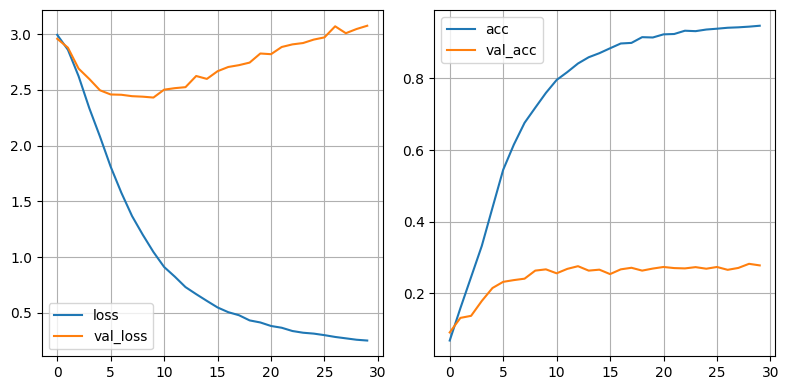

In [ ]:
plot_history(history)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 96)           480000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10304     
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
Total params: 491604 (1.88 MB)
Trainable params: 491604 (1.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Note that the `SimpleRNN` layer has output shape `(None, 64)`. `None` refers to the "variable" or automatically-detected batch size. `64` is the number of units in the simple RNN layer. The layer has 10,304 parameters, which can be explained by the expression: 10,304 = (64 units + input depth 96 + 1 bias) &times; 64 units.

The model is used for making predictions for, or classifying, some simple messages below.

In [ ]:
for text in ["i want to buy a computer",
             "read about romantic stories",
             "watch a boring ball game"]:
    print(f"{text} -> {predict_newsgroup(model, text)}")

i want to buy a computer -> (4, 'comp.sys.mac.hardware')
read about romantic stories -> (19, 'talk.religion.misc')
watch a boring ball game -> (10, 'rec.sport.hockey')


## Using LSTM

This code classifies the 20 newsgroups text dataset using LSTM.

In [ ]:
X, y = load_and_prep_20newsgroups()
model = keras.Sequential([
    layers.Embedding(NUM_WORDS, WV_SIZE, input_length=SEQ_LEN),
    layers.LSTM(64, dropout=0.5),
    layers.Dense(20, activation="softmax")
])

history = compile_and_fit_model(model, X, y)
print(history_final_values(history))

Epoch 1/30
36/36 - 13s - loss: 2.9849 - acc: 0.0835 - val_loss: 2.9641 - val_acc: 0.0950 - 13s/epoch - 353ms/step
Epoch 2/30
36/36 - 8s - loss: 2.8237 - acc: 0.1211 - val_loss: 2.6498 - val_acc: 0.1480 - 8s/epoch - 209ms/step
Epoch 3/30
36/36 - 8s - loss: 2.4667 - acc: 0.1918 - val_loss: 2.3692 - val_acc: 0.1865 - 8s/epoch - 228ms/step
Epoch 4/30
36/36 - 7s - loss: 2.2286 - acc: 0.2488 - val_loss: 2.2860 - val_acc: 0.2232 - 7s/epoch - 188ms/step
Epoch 5/30
36/36 - 7s - loss: 2.0808 - acc: 0.2976 - val_loss: 2.1965 - val_acc: 0.2572 - 7s/epoch - 200ms/step
Epoch 6/30
36/36 - 7s - loss: 1.9552 - acc: 0.3394 - val_loss: 2.1860 - val_acc: 0.2700 - 7s/epoch - 183ms/step
Epoch 7/30
36/36 - 6s - loss: 1.8394 - acc: 0.3745 - val_loss: 2.0972 - val_acc: 0.2992 - 6s/epoch - 168ms/step
Epoch 8/30
36/36 - 5s - loss: 1.7098 - acc: 0.4203 - val_loss: 2.0122 - val_acc: 0.3292 - 5s/epoch - 151ms/step
Epoch 9/30
36/36 - 6s - loss: 1.6050 - acc: 0.4607 - val_loss: 1.9748 - val_acc: 0.3509 - 6s/epoch - 1

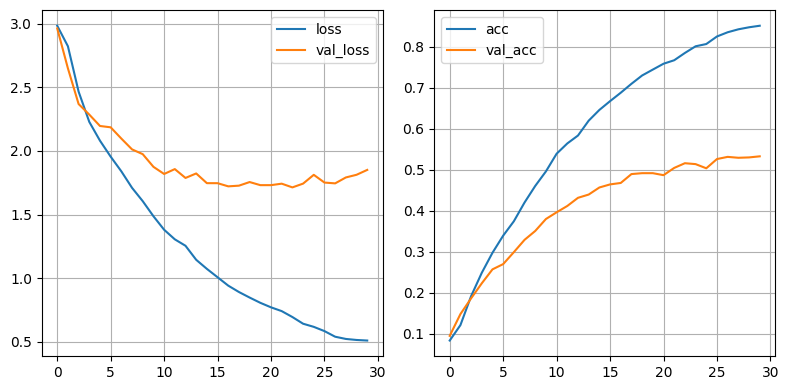

In [ ]:
plot_history(history)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 96)           480000    
                                                                 
 lstm (LSTM)                 (None, 64)                41216     
                                                                 
 dense_1 (Dense)             (None, 20)                1300      
                                                                 
Total params: 522516 (1.99 MB)
Trainable params: 522516 (1.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Note that the LSTM layer has output shape `(None, 64)`. `None` refers to the "variable" or automatically-detected batch size. `64` is the number of units in the LSTM layer. The layer has 41,216 parameters, which can be explained by the expression: 41,216 = 4 &times; (64 units + input depth 96 + 1 bias) &times; 64 units.

# Practice - Question 1 of 3

## Using GRU

## Q1a

Modify the above LSTM model to use GRU instead. Plot the training history and show the model summary.

In [13]:
X, y = load_and_prep_20newsgroups()
model = keras.Sequential([
    layers.Embedding(NUM_WORDS, WV_SIZE, input_length=SEQ_LEN),
    layers.GRU(64, dropout=0.5),#Use GRU layer instack of LSTM
    layers.Dense(20, activation="softmax")
])

history = compile_and_fit_model(model, X, y)
print(history_final_values(history))

Epoch 1/30
36/36 - 17s - loss: 2.9885 - acc: 0.0823 - val_loss: 2.9792 - val_acc: 0.1100 - 17s/epoch - 463ms/step
Epoch 2/30
36/36 - 8s - loss: 2.9422 - acc: 0.1421 - val_loss: 2.8916 - val_acc: 0.1175 - 8s/epoch - 223ms/step
Epoch 3/30
36/36 - 8s - loss: 2.7438 - acc: 0.1746 - val_loss: 2.6512 - val_acc: 0.1467 - 8s/epoch - 223ms/step
Epoch 4/30
36/36 - 7s - loss: 2.4600 - acc: 0.2278 - val_loss: 2.4831 - val_acc: 0.2165 - 7s/epoch - 188ms/step
Epoch 5/30
36/36 - 8s - loss: 2.2477 - acc: 0.2985 - val_loss: 2.3245 - val_acc: 0.2298 - 8s/epoch - 222ms/step
Epoch 6/30
36/36 - 9s - loss: 2.0110 - acc: 0.3475 - val_loss: 2.2024 - val_acc: 0.2647 - 9s/epoch - 242ms/step
Epoch 7/30
36/36 - 9s - loss: 1.8129 - acc: 0.4212 - val_loss: 2.1059 - val_acc: 0.2952 - 9s/epoch - 247ms/step
Epoch 8/30
36/36 - 7s - loss: 1.6522 - acc: 0.4766 - val_loss: 2.0568 - val_acc: 0.3288 - 7s/epoch - 192ms/step
Epoch 9/30
36/36 - 7s - loss: 1.5323 - acc: 0.5123 - val_loss: 2.1033 - val_acc: 0.3252 - 7s/epoch - 1

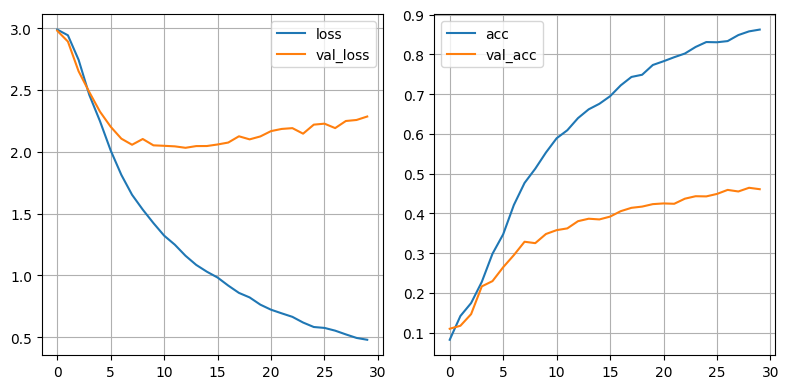

In [14]:
plot_history(history)

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 96)           480000    
                                                                 
 gru (GRU)                   (None, 64)                31104     
                                                                 
 dense_1 (Dense)             (None, 20)                1300      
                                                                 
Total params: 512404 (1.95 MB)
Trainable params: 512404 (1.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Q1b

What is the output shape of the GRU layer in this model? Explain the numbers (i.e. dimensions) in the output shape.

What is the number of parameters of the GRU layer in this model? Explain the number by writing an expression for calculating it, and describing the key terms in the expression.

Write your answer in a text cell below.

Solution:


<div class='alert alert-warning' role='alert'><b>

The output shape of the GRU layer is (None, 64). The output of the GRU layer has the same batch size as the input (represented by None), and 64 is the number of output features or dimensions.And 3 dimension .

num_params = 3x(64 +96 + 1)= 31104

Therefore, the number of parameters in the GRU layer is 31104.</b></div>


## &#x2766;

# Practice - Question 2 of 3

## Using stacked RNN

## Q2a

Modify the above LSTM model to use a stack of 2 LSTM layers instead of 1 LSTM layer. Plot the training history and show the model summary. (Hint: Remember to specify the argument `return_sequences=True` in the first LSTM layer.)

In [36]:
X, y = load_and_prep_20newsgroups()
model = keras.Sequential([
    layers.Embedding(NUM_WORDS, WV_SIZE, input_length=SEQ_LEN),
    layers.LSTM(64, dropout=0.5, return_sequences=True),#USe
    layers.LSTM(64, dropout=0.5) ,
    layers.Dense(20, activation="softmax")
])

history = compile_and_fit_model(model, X, y)
print(history_final_values(history))

Epoch 1/30
36/36 - 14s - loss: 2.9694 - acc: 0.0792 - val_loss: 2.8484 - val_acc: 0.0999 - 14s/epoch - 399ms/step
Epoch 2/30
36/36 - 8s - loss: 2.6634 - acc: 0.1236 - val_loss: 2.5774 - val_acc: 0.1352 - 8s/epoch - 215ms/step
Epoch 3/30
36/36 - 10s - loss: 2.3880 - acc: 0.1777 - val_loss: 2.3820 - val_acc: 0.1838 - 10s/epoch - 264ms/step
Epoch 4/30
36/36 - 8s - loss: 2.1569 - acc: 0.2354 - val_loss: 2.1946 - val_acc: 0.2510 - 8s/epoch - 211ms/step
Epoch 5/30
36/36 - 8s - loss: 1.9626 - acc: 0.3062 - val_loss: 2.1357 - val_acc: 0.2713 - 8s/epoch - 214ms/step
Epoch 6/30
36/36 - 8s - loss: 1.8340 - acc: 0.3506 - val_loss: 2.0255 - val_acc: 0.3018 - 8s/epoch - 228ms/step
Epoch 7/30
36/36 - 6s - loss: 1.7153 - acc: 0.3928 - val_loss: 1.9845 - val_acc: 0.3288 - 6s/epoch - 176ms/step
Epoch 8/30
36/36 - 6s - loss: 1.6018 - acc: 0.4443 - val_loss: 1.9864 - val_acc: 0.3363 - 6s/epoch - 157ms/step
Epoch 9/30
36/36 - 6s - loss: 1.5422 - acc: 0.4578 - val_loss: 2.0190 - val_acc: 0.3433 - 6s/epoch -

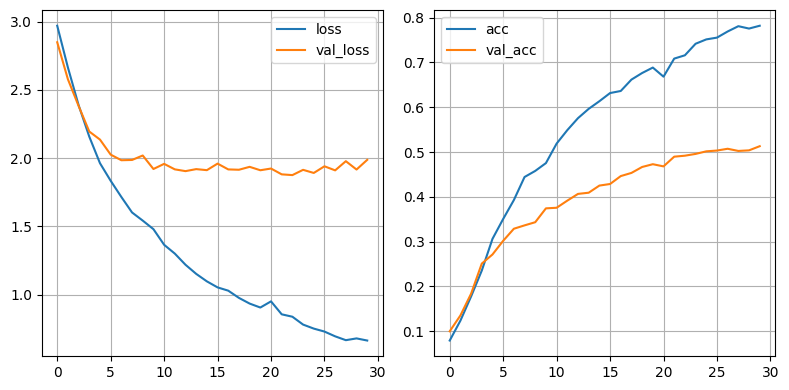

In [37]:
plot_history(history)

In [35]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 96)           480000    
                                                                 
 lstm_9 (LSTM)               (None, 100, 64)           41216     
                                                                 
 lstm_10 (LSTM)              (None, 64)                33024     
                                                                 
 dense_10 (Dense)            (None, 20)                1300      
                                                                 
Total params: 555540 (2.12 MB)
Trainable params: 555540 (2.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Q2b

What is the output shape of the first LSTM layer in this model? Explain the numbers (i.e. dimensions) in the output shape.

What is the number of parameters of the first LSTM layer in this model? Explain the number by writing an expression for calculating it, and describing the key terms in the expression.

Write your answer in a text cell below.

Solution:


<div class='alert alert-warning' role='alert'><b>

the LSTM layer has output shape (None, 64). None refers to the "variable" or automatically-detected batch size. 64 is the number of units in the LSTM layer. The layer has 41,216 parameters, which can be explained by the expression: 41,216 = 4 × (64 units + input depth 96 + 1 bias) × 64 units.

Therefore, the number of parameters in the first LSTM layer is 41216.</b></div>


## &#x2766;

# Practice - Question 3 of 3

## Using bidirectional RNN

## Q3a

Modify the above LSTM model (with 1 LSTM layer) to use a bidirectional LSTM layer. Plot the training history and show the model summary. (Hint: Use `layers.Bidirectional(layers.LSTM(...))`.)

In [21]:
X, y = load_and_prep_20newsgroups()
model = keras.Sequential([
    layers.Embedding(NUM_WORDS, WV_SIZE, input_length=SEQ_LEN),
    layers.Bidirectional(layers.LSTM(64, dropout=0.5)),
    layers.Dense(20, activation="softmax")
])

history = compile_and_fit_model(model, X, y)
print(history_final_values(history))


Epoch 1/30
36/36 - 15s - loss: 2.9800 - acc: 0.0780 - val_loss: 2.9495 - val_acc: 0.0937 - 15s/epoch - 404ms/step
Epoch 2/30
36/36 - 7s - loss: 2.8111 - acc: 0.1201 - val_loss: 2.6217 - val_acc: 0.1578 - 7s/epoch - 198ms/step
Epoch 3/30
36/36 - 8s - loss: 2.5135 - acc: 0.1912 - val_loss: 2.4379 - val_acc: 0.2028 - 8s/epoch - 225ms/step
Epoch 4/30
36/36 - 7s - loss: 2.2698 - acc: 0.2393 - val_loss: 2.2853 - val_acc: 0.2324 - 7s/epoch - 196ms/step
Epoch 5/30
36/36 - 7s - loss: 2.0639 - acc: 0.3009 - val_loss: 2.1175 - val_acc: 0.2775 - 7s/epoch - 194ms/step
Epoch 6/30
36/36 - 7s - loss: 1.8558 - acc: 0.3663 - val_loss: 2.0120 - val_acc: 0.3195 - 7s/epoch - 198ms/step
Epoch 7/30
36/36 - 6s - loss: 1.7405 - acc: 0.4028 - val_loss: 1.9806 - val_acc: 0.3425 - 6s/epoch - 158ms/step
Epoch 8/30
36/36 - 6s - loss: 1.6115 - acc: 0.4466 - val_loss: 1.8806 - val_acc: 0.3743 - 6s/epoch - 162ms/step
Epoch 9/30
36/36 - 6s - loss: 1.4961 - acc: 0.4832 - val_loss: 1.8304 - val_acc: 0.3862 - 6s/epoch - 1

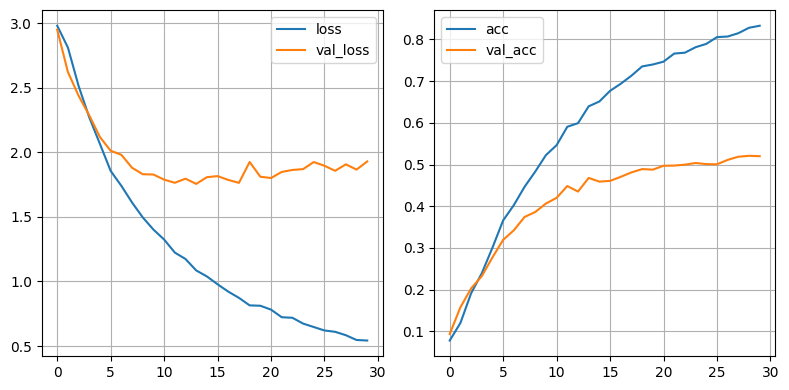

In [22]:
plot_history(history)

In [23]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 96)           480000    
                                                                 
 bidirectional (Bidirection  (None, 128)               82432     
 al)                                                             
                                                                 
 dense_5 (Dense)             (None, 20)                2580      
                                                                 
Total params: 565012 (2.16 MB)
Trainable params: 565012 (2.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Q3b

What is the output shape of the bidirectional layer in this model? Explain the numbers (i.e. dimensions) in the output shape.

What is the number of parameters of the bidirectional layer in this model? Explain the number by writing an expression for calculating it, and describing the key terms in the expression.

Write your answer in a text cell below.

Solution:


<div class='alert alert-warning' role='alert'><b>
the bidirectional layer has output shape (None, 128). None refers to the "variable" or automatically-detected batch size. 64 is the number of units in the bidirectional layer. The layer has 82432 parameters, which can be explained by the expression: 41,216 = 4 × (64 units + input depth 96 + 1 bias) × 128 units.</b></div>


## Q3c

A template table is provided below.

Model | Val Loss | Val Accuracy | Param # in recurrent layer(s)
:-:|:-:|:-:|:-:
Simple RNN | 3.0749 | 0.2775 | 10,304
LSTM | 1.8509 | 0.5329 | 41,216
GRU | ? | ? | ?
Stacked RNN | ? | ? | ?
Bidirectional RNN | ? | ? | ?

Make a copy of the table. Referring to the execution outputs of the above models, fill in the validation results and numbers of parameters in the recurrent layer(s) for each model in the table. For the stacked LSTM model, give the total number of parameters in the 2 LSTM layers.

Solution:

Model | Val Loss | Val Accuracy | Param # in recurrent layer(s)
:-:|:-:|:-:|:-:
Simple RNN | 3.0749 | 0.2775 | 10,304
LSTM | 1.8509 | 0.5329 | 41,216
GRU | 2.2853 | 0.4609 | 31,104
Stacked RNN | 1.9873 | 0.5130 | 41216 + 33024 = 74,240
Bidirectional RNN | 1.9293 | 0.5201 | 82,432

## &#x2766;

# Extras

In this section, we use a recurrent network to generate text of a hopefully meaningful passage.

## Text generation

Text can be generated word by word using a recurrent network model, which is trained to predict, or generate, the next word from a given sequence of words. To train the model, we use a long text, such as a fiction, as training examples. A training example is a run of $n+1$ consecutive words, where the first $n$ words (a sequence) are the features, and the final word is the label.

When the model has been trained, text is generated by specifying some seed text as features to predict the next word, appending the new word to the seed text and repeating the prediction; the process continues until enough words have been generated. In text generation, we do not always select the "best" word which has the highest predicted probability. It is desirable to apply some randomness in choosing the generated word so that the generated contents have some variations.

Let's look at the code. The following code loads the text from a file and cleans up the text.

In [ ]:
import re

START_PATTERN = r"\*\*\* START OF THE PROJECT GUTENBERG EBOOK .* \*\*\*"
END_PATTERN = r"\*\*\* END OF THE PROJECT GUTENBERG EBOOK .* \*\*\*"
PUNCTUATION_PATTERN = '([!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~])'

def load_and_cleanup_text(filename):
    with open(filename) as f:
        text = f.read()
    start = re.search(START_PATTERN, text).end()
    stop = re.search(END_PATTERN, text).start()
    text = text[start:stop]     # remove gutenbery header and footer
    text = text.lower()         # convert to lowercase
    text = re.sub(PUNCTUATION_PATTERN, r" \1 ", text)
                                # remove punctuation
    text = text.replace("\n", " ")   # convert end-of-lines to spaces
    text = re.sub("  +", " ", text)  # clean consecutive spaces
    text = text.strip()         # remove beginning and ending spaces
    return text

These are some import statements and constant definitions.

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

NUM_WORDS = 5000    # how many most frequent words in the corpus to use
NUM_SKIP_WORDS = 0  # how many stop words to skip
WV_SIZE = 96        # word vector size, 96D, each vector having 96 values
SEQ_LEN = 20        # standardized length of text after padding/truncating

This function tokenizes the text, i.e. breaking the text into words.

In [ ]:
def tokenize_text(text):
    tokenizer = Tokenizer(num_words=NUM_WORDS, filters="")
    tokenizer.fit_on_texts([text])
    token_list = tokenizer.texts_to_sequences([text])[0]
    return tokenizer, token_list

This function generates a dataset of examples from the text.

In [ ]:
def generate_text_dataset(token_list):
    X, y = [], []
    for i in range(0, len(token_list) - SEQ_LEN):
        X.append(token_list[i: i + SEQ_LEN])
        y.append(token_list[i + SEQ_LEN])
    y = to_categorical(y, num_classes = NUM_WORDS)
    return np.array(X), np.array(y)

We use the text of Alice's Adventures in Wonderland by Lewis Carroll to train the model. This shell command downloads the text from the Project Gutenbery website.

In [ ]:
![ -f alice.txt ] || curl -o alice.txt \
https://www.gutenberg.org/cache/epub/11/pg11.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  170k  100  170k    0     0   382k      0 --:--:-- --:--:-- --:--:--  383k


This code loads the text and prepares the dataset. Then, it creates, configures, and trains a model.

In [ ]:
keras.utils.set_random_seed(42)
text = load_and_cleanup_text("alice.txt")
tokenizer, token_list = tokenize_text(text)
X, y = generate_text_dataset(token_list)

model = keras.Sequential([
    layers.Embedding(NUM_WORDS, WV_SIZE, input_length=SEQ_LEN),
    layers.LSTM(128, dropout=0.2),
    layers.Dense(NUM_WORDS, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["acc"])
history = model.fit(X, y, epochs=20, batch_size=32)

Epoch 1/20
1032/1032 [==============================] - 36s 32ms/step - loss: 6.0020 - acc: 0.0896
Epoch 2/20
1032/1032 [==============================] - 17s 17ms/step - loss: 5.2746 - acc: 0.1416
Epoch 3/20
1032/1032 [==============================] - 17s 16ms/step - loss: 4.8664 - acc: 0.1673
Epoch 4/20
1032/1032 [==============================] - 16s 16ms/step - loss: 4.5330 - acc: 0.1928
Epoch 5/20
1032/1032 [==============================] - 16s 16ms/step - loss: 4.2684 - acc: 0.2103
Epoch 6/20
1032/1032 [==============================] - 17s 16ms/step - loss: 4.0452 - acc: 0.2288
Epoch 7/20
1032/1032 [==============================] - 16s 15ms/step - loss: 3.8419 - acc: 0.2443
Epoch 8/20
1032/1032 [==============================] - 17s 16ms/step - loss: 3.6578 - acc: 0.2584
Epoch 9/20
1032/1032 [==============================] - 16s 16ms/step - loss: 3.4825 - acc: 0.2757
Epoch 10/20
1032/1032 [==============================] - 16s 16ms/step - loss: 3.3199 - acc: 0.2927
Epoch 11/

The `sample_word()` function below selects, or samples, a word from the available words with predicted probabilities. The temperature parameter is a value between 0.0 and 1.0. A small temperature value further emphasizes the highest predicted probability and makes word selection more deterministic, while a large temperature value lets word selection follow the predicted probabilities with relatively more variations.

In [ ]:
def sample_word(preds, temperature):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds + np.finfo("float64").eps) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probs = np.random.multinomial(1, preds, 1)
    return np.argmax(probs)

This function actually generates the words using the trained model.

In [ ]:
def generate_text(seed_text, num_gen_words, model, tokenizer, temperature):
    padding = ". " * SEQ_LEN  # handle too short seed text
    seed_text = padding + seed_text
    text = seed_text
    for i in range(num_gen_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = token_list[-SEQ_LEN:]
        token_list = np.reshape(token_list, (1, SEQ_LEN))
        probs = model.predict(token_list, verbose=0)[0]
        word_idx = sample_word(probs, temperature)
        word = tokenizer.index_word[word_idx] if word_idx > 0 else ""
        seed_text += word + " "
        text += word + " "
    return text[len(padding):]

Three passages are generated below, with temperature values of 1.0, 0.5 and 0.2.

In [ ]:
generate_text("good morning ", 200, model, tokenizer, 1.0)

'good morning , ” continued the king to the mock turtle . “i’m afraid what makes the world ! ” alice added ; “but those mean , of not me shoes about particular ? ” thought the duchess , “till the jurymen is very frightened at this , that she did not dare to be involved that or day for this p found it was like . said the duchess : “we’re all come back into a fashion , that’s all , i father only thing when i can’t get to my , for time five was just come at me upon this affair , then , it hall , saying to two almost walk the earth lessons by all . “oh , you had heard a long inside , ” thought alice , in a hatter in the air . “are i you mean it round the last witness . ” added alice . “reeling and writhing , digging of mustard , ” the hatter went on , without considering of it all brightened up with little cakes there was all like her ; quite only out of this , saying every . first , you finished , ” said the '

In [ ]:
generate_text("good morning ", 200, model, tokenizer, 0.5)

'good morning you’ve taken write you ? ” alice replied very readily . “i mean you , ” said the mock turtle . “seals , turtles , salmon , that , i should put it away ! ” “ah , please , for all the same - thing i’ve got ! ” said the queen , who seemed to be full of the officers of the garden . ” and they got on the verses , and began whistling . “why , ” said the dodo . “fetch me a whiting , ” said the mock turtle . alice was not much frightened and the same thing , but it over it so long as she had never put such a pleasant thing of it . ) presently she was a little scream of laughter . alice waited patiently until she noticed it would be afraid of interrupting him , and she ; “some of the jurors were saying to the game . ” alice did not dare to disobey , and had grown so much contradicted in this time in a minute or two . she was not much surprised at it , and she was still muttering to her : '

In [ ]:
generate_text("good morning ", 200, model, tokenizer, 0.2)

'good morning you’ve washing _ you _ , ” said the hatter . “i don’t know it , ” said the mock turtle . “certainly not , ” said the caterpillar . alice looked at the top of the blades of grass , and looked at the gryphon , and the gryphon was looking at the door , and she went on , “—likely to win , and reduced the waters of the nile on every golden scale ! who stole me ! ” the duchess said , turning to the jury , who instantly made the list of singers the song , and the dormouse was sitting on the ground all the white rabbit , who was peeping anxiously into the distance , and tumbled eyes immediately met in the distance . she did not like the look of the singers . the dormouse shook his head impatiently , and the hatter was the hatter , and the hatter was the white rabbit , trotting slowly on the middle , and knocked . “there’s a curious plan , ” said the duchess . “i never wouldn’t be so proud as it , ” said the mock turtle , “but i can’t '

### E1a

Create another model to be trained using the text of Frankenstein, by Mary Wollstonecraft Shelley. The text can be downloaded using the following shell command.

In [ ]:
![ -f frankenstein.txt ] || curl -o frankenstein.txt \
https://www.gutenberg.org/cache/epub/84/pg84.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  438k  100  438k    0     0   993k      0 --:--:-- --:--:-- --:--:--  994k


### E1b

Generate 3 passages using this model with temperature values of 1.0, 0.5, and 0.2.

## Solutions to extra exercises

### E1a

In [ ]:
keras.utils.set_random_seed(42)
text = load_and_cleanup_text("frankenstein.txt")
tokenizer, token_list = tokenize_text(text)
X, y = generate_text_dataset(token_list)

model = keras.Sequential([
    layers.Embedding(NUM_WORDS, WV_SIZE, input_length=SEQ_LEN),
    layers.LSTM(128, dropout=0.2),
    layers.Dense(NUM_WORDS, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["acc"])
history = model.fit(X, y, epochs=20, batch_size=32)

Epoch 1/20
2587/2587 [==============================] - 57s 21ms/step - loss: 5.9225 - acc: 0.1013
Epoch 2/20
2587/2587 [==============================] - 43s 17ms/step - loss: 5.2544 - acc: 0.1500
Epoch 3/20
2587/2587 [==============================] - 43s 17ms/step - loss: 4.9280 - acc: 0.1742
Epoch 4/20
2587/2587 [==============================] - 43s 17ms/step - loss: 4.6751 - acc: 0.1890
Epoch 5/20
2587/2587 [==============================] - 43s 17ms/step - loss: 4.4481 - acc: 0.2013
Epoch 6/20
2587/2587 [==============================] - 43s 17ms/step - loss: 4.2460 - acc: 0.2129
Epoch 7/20
2587/2587 [==============================] - 43s 17ms/step - loss: 4.0565 - acc: 0.2266
Epoch 8/20
2587/2587 [==============================] - 47s 18ms/step - loss: 3.8806 - acc: 0.2406
Epoch 9/20
2587/2587 [==============================] - 43s 16ms/step - loss: 3.7149 - acc: 0.2559
Epoch 10/20
2587/2587 [==============================] - 44s 17ms/step - loss: 3.5597 - acc: 0.2735
Epoch 11/

### E1b

In [ ]:
generate_text("good morning ", 200, model, tokenizer, 1.0)

'good morning , “it , the wondrous and opened , with the wilds of the light to the garden , and she down to see playing with animation , nearly afterwards about clerval to me in the cabin of receiving . yet why without my misfortunes i have been possessed by that manner by a thousand minute , and must see himself to inflict otherwise who feared , then i found this shelter . o human light are and conciliating and happy ; i was educated by one of , and despite the ardour of that he heard that i were into the discoveries of the impossible . yet i showed vessels them round my chief person had high , they scream , my property , which was absolutely blunt violent ; all seemed to me from his present , which he lay on the stillness of which , on its discovery necessary that the fiend was ; the lost lasted of the death succeed , and the dashing of the nearly passion from which which otherwise stood fled to them , which his visits are indeed more bound than happy who will have right to any light

In [ ]:
generate_text("good morning ", 200, model, tokenizer, 0.5)

'good morning the high mountains of the town met a turk , and i will defend my determination . i confess that i have no ties and persuade myself on the lives of my being ; but when i thought that i will not be and feeble . ” i trembled violently and i had suffered right , and i withdrew by the cabin . i was on the spot where the body had not been employed , and in the midst of national and professional prejudices , unsoftened by joy , and spent in the most beautiful of the family , but the green hills want and abhorred . the old man , leaving the first hour of his companions , i perceived that the night before not not yet calm . he was the same candour , and the youth rose , and she beheld my mind as her friends , to her own sister , and which i had left to be repaired to the land of lucerne and . in the meantime he took up the instrument of some , which had drifted across the fields of the land of singular land . i saw the lectures and '

In [ ]:
generate_text("good morning ", 200, model, tokenizer, 0.2)

'good morning , “for the dæmon , i perceived the crowd where the moon had given life , but i had no cause for the same . i had risen , i had no right to share their intercourse . my life was indeed , and i could not help believing that i had lost some other wickedness . i have wandered out of the town for a few moments i had formerly endured . i have no friend , but i was unable to discover that the wind of day , and the lives of my destruction . i shall proceed with a letter on the prospect which i cannot yet imagine . you will rejoice to take place a little proud and perhaps , but i am not so selfish and dear as the of your fellow creatures . ” i trembled , and i could not bring myself to the whole town , of the same time awakened to the solid advantage of mankind . ” i trembled violently and , and i could not answer by the of the town , for i first saw him , and the result of my father were misfortunes to the study '

## &#x2766;